In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]
ZR_12_TR, ZR_12_TE= ZR_12[0:50], ZR_12[50:len(ZR_12)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]
ZR_N12=ZR_N[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]
ZR_N12_TR, ZR_N12_TE= ZR_N12[0:50], ZR_N12[50:len(ZR_N12)]

In [6]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back, look_forward):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [7]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+1
look_back=12
look_forward=1

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)
trainX_100, train_y_100 = ZR_100_TR_I.iloc[:, 0:-1], ZR_100_TR_I.iloc[:, -1]

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)
testX_100, test_y_100 = ZR_100_TE_I.iloc[:, 0:-1], ZR_100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_46_TR_I=timeseries_to_supervised_R(ZR_46_TR, look_back, look_forward)
trainX_46, train_y_46 = ZR_46_TR_I.iloc[:, 0:-1], ZR_46_TR_I.iloc[:, -1]

# Testdaten 
ZR_46_TE_I=timeseries_to_supervised_R(ZR_46_TE, look_back, look_forward)
testX_46, test_y_46 = ZR_46_TE_I.iloc[:, 0:-1], ZR_46_TE_I.iloc[:, -1]


# Inputgröße 12%
# Trainingsdaten
ZR_12_TR_I=timeseries_to_supervised_R(ZR_12_TR, look_back, look_forward)
trainX_12, train_y_12 = ZR_12_TR_I.iloc[:, 0:-1], ZR_12_TR_I.iloc[:, -1]

# Testdaten 
ZR_12_TE_I=timeseries_to_supervised_R(ZR_12_TE, look_back, look_forward)
testX_12, test_y_12 = ZR_12_TE_I.iloc[:, 0:-1], ZR_12_TE_I.iloc[:, -1]

In [8]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)
trainX_100N, train_y_100N = ZR_N100_TR_I.iloc[:, 0:-1], ZR_N100_TR_I.iloc[:, -1]

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)
testX_100N, test_y_100N = ZR_N100_TE_I.iloc[:, 0:-1], ZR_N100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_N46_TR_I=timeseries_to_supervised_R(ZR_N46_TR, look_back, look_forward)
trainX_46N, train_y_46N = ZR_N46_TR_I.iloc[:, 0:-1], ZR_N46_TR_I.iloc[:, -1]

# Testdaten 
ZR_N46_TE_I=timeseries_to_supervised_R(ZR_N46_TE, look_back, look_forward)
testX_46N, test_y_46N = ZR_N46_TE_I.iloc[:, 0:-1], ZR_N46_TE_I.iloc[:, -1]


# Inputgröße 12%
# Trainingsdaten
ZR_N12_TR_I=timeseries_to_supervised_R(ZR_N12_TR, look_back, look_forward)
trainX_12N, train_y_12N = ZR_N12_TR_I.iloc[:, 0:-1], ZR_N12_TR_I.iloc[:, -1]

# Testdaten 
ZR_N12_TE_I=timeseries_to_supervised_R(ZR_N12_TE, look_back, look_forward)
testX_12N, test_y_12N = ZR_N12_TE_I.iloc[:, 0:-1], ZR_N12_TE_I.iloc[:, -1]

In [18]:
# neuer Code: Optimierung der Gewichte
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
k =20
test_MSE=[0]*k
for i in range(k):
    np.random.seed(i)
    model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))
    testPredict_100N = model.predict(testX_100N)
    testPredict_100=scaler.inverse_transform(testPredict_100N)
    test_MSE[i]=mean_squared_error(test_y_100,testPredict_100)

Train on 593 samples, validate on 246 samples
Epoch 1/200
 - 0s - loss: 0.0853 - val_loss: 0.1921
Epoch 2/200
 - 0s - loss: 0.0643 - val_loss: 0.1512
Epoch 3/200
 - 0s - loss: 0.0497 - val_loss: 0.1130
Epoch 4/200
 - 0s - loss: 0.0378 - val_loss: 0.0777
Epoch 5/200
 - 0s - loss: 0.0287 - val_loss: 0.0590
Epoch 6/200
 - 0s - loss: 0.0215 - val_loss: 0.0372
Epoch 7/200
 - 0s - loss: 0.0163 - val_loss: 0.0277
Epoch 8/200
 - 0s - loss: 0.0125 - val_loss: 0.0192
Epoch 9/200
 - 0s - loss: 0.0098 - val_loss: 0.0126
Epoch 10/200
 - 0s - loss: 0.0079 - val_loss: 0.0090
Epoch 11/200
 - 0s - loss: 0.0064 - val_loss: 0.0057
Epoch 12/200
 - 0s - loss: 0.0055 - val_loss: 0.0044
Epoch 13/200
 - 0s - loss: 0.0048 - val_loss: 0.0032
Epoch 14/200
 - 0s - loss: 0.0044 - val_loss: 0.0029
Epoch 15/200
 - 0s - loss: 0.0042 - val_loss: 0.0026
Epoch 16/200
 - 0s - loss: 0.0039 - val_loss: 0.0025
Epoch 17/200
 - 0s - loss: 0.0038 - val_loss: 0.0026
Epoch 18/200
 - 0s - loss: 0.0037 - val_loss: 0.0025
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 155/200
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 156/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 157/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 158/200
 - 0s - loss: 0.0018 - val_loss: 0.0011
Epoch 159/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 160/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 161/200
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 162/200
 - 0s - loss: 0.0020 - val_loss: 0.0013
Epoch 163/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 164/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 165/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 166/200
 - 0s - loss: 0.0018 - val_loss: 0.0011
Epoch 167/200
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 168/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 169/200
 - 0s - loss: 0.0018 - val_loss: 0.0011
Epoch 170/200
 - 0s - loss: 0.0018 - val_loss: 0.0014
Epoch 171/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 172/200
 - 0s - loss: 

Epoch 102/200
 - 0s - loss: 0.0017 - val_loss: 9.1787e-04
Epoch 103/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 104/200
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 105/200
 - 0s - loss: 0.0018 - val_loss: 9.1742e-04
Epoch 106/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 107/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 108/200
 - 0s - loss: 0.0018 - val_loss: 9.3866e-04
Epoch 109/200
 - 0s - loss: 0.0017 - val_loss: 9.4381e-04
Epoch 110/200
 - 0s - loss: 0.0017 - val_loss: 9.1614e-04
Epoch 111/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 112/200
 - 0s - loss: 0.0018 - val_loss: 9.3683e-04
Epoch 113/200
 - 0s - loss: 0.0017 - val_loss: 9.8820e-04
Epoch 114/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 115/200
 - 0s - loss: 0.0018 - val_loss: 9.3080e-04
Epoch 116/200
 - 0s - loss: 0.0017 - val_loss: 0.0012
Epoch 117/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 118/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 119/200
 - 0s - loss: 0.0017 - val_loss: 9.5

Epoch 46/200
 - 0s - loss: 0.0018 - val_loss: 9.2880e-04
Epoch 47/200
 - 0s - loss: 0.0017 - val_loss: 9.7849e-04
Epoch 48/200
 - 0s - loss: 0.0017 - val_loss: 9.0175e-04
Epoch 49/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 50/200
 - 0s - loss: 0.0017 - val_loss: 9.0643e-04
Epoch 51/200
 - 0s - loss: 0.0018 - val_loss: 9.6688e-04
Epoch 52/200
 - 0s - loss: 0.0017 - val_loss: 9.4290e-04
Epoch 53/200
 - 0s - loss: 0.0017 - val_loss: 9.2004e-04
Epoch 54/200
 - 0s - loss: 0.0017 - val_loss: 0.0013
Epoch 55/200
 - 0s - loss: 0.0018 - val_loss: 9.1514e-04
Epoch 56/200
 - 0s - loss: 0.0017 - val_loss: 9.4225e-04
Epoch 57/200
 - 0s - loss: 0.0017 - val_loss: 9.0346e-04
Epoch 58/200
 - 0s - loss: 0.0017 - val_loss: 9.8943e-04
Epoch 59/200
 - 0s - loss: 0.0017 - val_loss: 9.0614e-04
Epoch 60/200
 - 0s - loss: 0.0017 - val_loss: 9.2364e-04
Epoch 61/200
 - 0s - loss: 0.0017 - val_loss: 9.4836e-04
Epoch 62/200
 - 0s - loss: 0.0018 - val_loss: 9.1574e-04
Epoch 63/200
 - 0s - loss: 0.0017 - val

Epoch 191/200
 - 0s - loss: 0.0018 - val_loss: 9.4642e-04
Epoch 192/200
 - 0s - loss: 0.0017 - val_loss: 9.0387e-04
Epoch 193/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 194/200
 - 0s - loss: 0.0017 - val_loss: 9.6176e-04
Epoch 195/200
 - 0s - loss: 0.0017 - val_loss: 9.0587e-04
Epoch 196/200
 - 0s - loss: 0.0017 - val_loss: 9.1845e-04
Epoch 197/200
 - 0s - loss: 0.0017 - val_loss: 9.3665e-04
Epoch 198/200
 - 0s - loss: 0.0017 - val_loss: 9.2272e-04
Epoch 199/200
 - 0s - loss: 0.0017 - val_loss: 9.2008e-04
Epoch 200/200
 - 0s - loss: 0.0017 - val_loss: 9.1884e-04
Train on 593 samples, validate on 246 samples
Epoch 1/200
 - 0s - loss: 0.0017 - val_loss: 9.2448e-04
Epoch 2/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 3/200
 - 0s - loss: 0.0017 - val_loss: 8.9974e-04
Epoch 4/200
 - 0s - loss: 0.0017 - val_loss: 9.3200e-04
Epoch 5/200
 - 0s - loss: 0.0017 - val_loss: 9.9742e-04
Epoch 6/200
 - 0s - loss: 0.0017 - val_loss: 9.2498e-04
Epoch 7/200
 - 0s - loss: 0.0017 - val_loss: 9

Epoch 135/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 136/200
 - 0s - loss: 0.0018 - val_loss: 8.9868e-04
Epoch 137/200
 - 0s - loss: 0.0017 - val_loss: 9.4145e-04
Epoch 138/200
 - 0s - loss: 0.0017 - val_loss: 9.0299e-04
Epoch 139/200
 - 0s - loss: 0.0017 - val_loss: 8.9990e-04
Epoch 140/200
 - 0s - loss: 0.0017 - val_loss: 9.7641e-04
Epoch 141/200
 - 0s - loss: 0.0017 - val_loss: 9.5019e-04
Epoch 142/200
 - 0s - loss: 0.0017 - val_loss: 9.7682e-04
Epoch 143/200
 - 0s - loss: 0.0017 - val_loss: 9.5269e-04
Epoch 144/200
 - 0s - loss: 0.0017 - val_loss: 9.0459e-04
Epoch 145/200
 - 0s - loss: 0.0019 - val_loss: 9.0045e-04
Epoch 146/200
 - 0s - loss: 0.0018 - val_loss: 9.8163e-04
Epoch 147/200
 - 0s - loss: 0.0017 - val_loss: 9.0030e-04
Epoch 148/200
 - 0s - loss: 0.0017 - val_loss: 9.0481e-04
Epoch 149/200
 - 0s - loss: 0.0017 - val_loss: 9.5880e-04
Epoch 150/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 151/200
 - 0s - loss: 0.0017 - val_loss: 9.1533e-04
Epoch 152/200
 - 0s - 

Epoch 79/200
 - 0s - loss: 0.0017 - val_loss: 8.9972e-04
Epoch 80/200
 - 0s - loss: 0.0018 - val_loss: 8.9400e-04
Epoch 81/200
 - 0s - loss: 0.0017 - val_loss: 9.3054e-04
Epoch 82/200
 - 0s - loss: 0.0017 - val_loss: 9.2546e-04
Epoch 83/200
 - 0s - loss: 0.0017 - val_loss: 9.1458e-04
Epoch 84/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 85/200
 - 0s - loss: 0.0017 - val_loss: 9.7061e-04
Epoch 86/200
 - 0s - loss: 0.0017 - val_loss: 9.4950e-04
Epoch 87/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 88/200
 - 0s - loss: 0.0017 - val_loss: 9.4128e-04
Epoch 89/200
 - 0s - loss: 0.0017 - val_loss: 8.9665e-04
Epoch 90/200
 - 0s - loss: 0.0017 - val_loss: 9.0209e-04
Epoch 91/200
 - 0s - loss: 0.0017 - val_loss: 9.0477e-04
Epoch 92/200
 - 0s - loss: 0.0017 - val_loss: 9.5326e-04
Epoch 93/200
 - 0s - loss: 0.0017 - val_loss: 9.0404e-04
Epoch 94/200
 - 0s - loss: 0.0017 - val_loss: 9.2456e-04
Epoch 95/200
 - 0s - loss: 0.0017 - val_loss: 9.4287e-04
Epoch 96/200
 - 0s - loss: 0.0017 - val

Epoch 22/200
 - 0s - loss: 0.0017 - val_loss: 9.1073e-04
Epoch 23/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 24/200
 - 0s - loss: 0.0018 - val_loss: 9.0684e-04
Epoch 25/200
 - 0s - loss: 0.0018 - val_loss: 9.4044e-04
Epoch 26/200
 - 0s - loss: 0.0017 - val_loss: 9.8842e-04
Epoch 27/200
 - 0s - loss: 0.0017 - val_loss: 9.3394e-04
Epoch 28/200
 - 0s - loss: 0.0017 - val_loss: 8.9687e-04
Epoch 29/200
 - 0s - loss: 0.0017 - val_loss: 9.4035e-04
Epoch 30/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 31/200
 - 0s - loss: 0.0017 - val_loss: 9.5946e-04
Epoch 32/200
 - 0s - loss: 0.0017 - val_loss: 9.6559e-04
Epoch 33/200
 - 0s - loss: 0.0017 - val_loss: 9.4713e-04
Epoch 34/200
 - 0s - loss: 0.0017 - val_loss: 9.3413e-04
Epoch 35/200
 - 0s - loss: 0.0017 - val_loss: 9.0935e-04
Epoch 36/200
 - 0s - loss: 0.0017 - val_loss: 9.0466e-04
Epoch 37/200
 - 0s - loss: 0.0017 - val_loss: 9.6501e-04
Epoch 38/200
 - 0s - loss: 0.0018 - val_loss: 8.9912e-04
Epoch 39/200
 - 0s - loss: 0.0017 - val

Epoch 166/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 167/200
 - 0s - loss: 0.0017 - val_loss: 9.1720e-04
Epoch 168/200
 - 0s - loss: 0.0017 - val_loss: 9.2574e-04
Epoch 169/200
 - 0s - loss: 0.0017 - val_loss: 9.8597e-04
Epoch 170/200
 - 0s - loss: 0.0017 - val_loss: 9.5279e-04
Epoch 171/200
 - 0s - loss: 0.0017 - val_loss: 8.9730e-04
Epoch 172/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 173/200
 - 0s - loss: 0.0017 - val_loss: 9.7977e-04
Epoch 174/200
 - 0s - loss: 0.0017 - val_loss: 9.2644e-04
Epoch 175/200
 - 0s - loss: 0.0017 - val_loss: 9.1814e-04
Epoch 176/200
 - 0s - loss: 0.0017 - val_loss: 9.0755e-04
Epoch 177/200
 - 0s - loss: 0.0017 - val_loss: 9.0355e-04
Epoch 178/200
 - 0s - loss: 0.0018 - val_loss: 9.5191e-04
Epoch 179/200
 - 0s - loss: 0.0017 - val_loss: 9.5386e-04
Epoch 180/200
 - 0s - loss: 0.0017 - val_loss: 9.0862e-04
Epoch 181/200
 - 0s - loss: 0.0017 - val_loss: 9.2059e-04
Epoch 182/200
 - 0s - loss: 0.0017 - val_loss: 8.9776e-04
Epoch 183/200
 - 0s - 

Epoch 110/200
 - 0s - loss: 0.0017 - val_loss: 9.6712e-04
Epoch 111/200
 - 0s - loss: 0.0017 - val_loss: 9.0165e-04
Epoch 112/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 113/200
 - 0s - loss: 0.0017 - val_loss: 9.0755e-04
Epoch 114/200
 - 0s - loss: 0.0017 - val_loss: 9.0153e-04
Epoch 115/200
 - 0s - loss: 0.0017 - val_loss: 9.0106e-04
Epoch 116/200
 - 0s - loss: 0.0017 - val_loss: 9.0642e-04
Epoch 117/200
 - 0s - loss: 0.0017 - val_loss: 9.5893e-04
Epoch 118/200
 - 0s - loss: 0.0017 - val_loss: 9.0263e-04
Epoch 119/200
 - 0s - loss: 0.0017 - val_loss: 9.6345e-04
Epoch 120/200
 - 0s - loss: 0.0017 - val_loss: 9.1803e-04
Epoch 121/200
 - 0s - loss: 0.0017 - val_loss: 8.9951e-04
Epoch 122/200
 - 0s - loss: 0.0017 - val_loss: 9.1877e-04
Epoch 123/200
 - 0s - loss: 0.0018 - val_loss: 9.8786e-04
Epoch 124/200
 - 0s - loss: 0.0017 - val_loss: 9.4169e-04
Epoch 125/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 126/200
 - 0s - loss: 0.0017 - val_loss: 8.9735e-04
Epoch 127/200
 - 0s - 

Epoch 53/200
 - 0s - loss: 0.0017 - val_loss: 9.0333e-04
Epoch 54/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 55/200
 - 0s - loss: 0.0018 - val_loss: 8.9859e-04
Epoch 56/200
 - 0s - loss: 0.0017 - val_loss: 9.6450e-04
Epoch 57/200
 - 0s - loss: 0.0017 - val_loss: 9.0074e-04
Epoch 58/200
 - 0s - loss: 0.0017 - val_loss: 8.9825e-04
Epoch 59/200
 - 0s - loss: 0.0018 - val_loss: 9.6219e-04
Epoch 60/200
 - 0s - loss: 0.0017 - val_loss: 9.9768e-04
Epoch 61/200
 - 0s - loss: 0.0017 - val_loss: 9.4070e-04
Epoch 62/200
 - 0s - loss: 0.0017 - val_loss: 9.0679e-04
Epoch 63/200
 - 0s - loss: 0.0017 - val_loss: 9.9246e-04
Epoch 64/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 65/200
 - 0s - loss: 0.0017 - val_loss: 8.9639e-04
Epoch 66/200
 - 0s - loss: 0.0017 - val_loss: 9.1166e-04
Epoch 67/200
 - 0s - loss: 0.0017 - val_loss: 9.6689e-04
Epoch 68/200
 - 0s - loss: 0.0017 - val_loss: 9.3622e-04
Epoch 69/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 70/200
 - 0s - loss: 0.0017 - val_los

Epoch 197/200
 - 0s - loss: 0.0018 - val_loss: 9.0008e-04
Epoch 198/200
 - 0s - loss: 0.0018 - val_loss: 9.3349e-04
Epoch 199/200
 - 0s - loss: 0.0017 - val_loss: 9.0828e-04
Epoch 200/200
 - 0s - loss: 0.0017 - val_loss: 9.0144e-04
Train on 593 samples, validate on 246 samples
Epoch 1/200
 - 0s - loss: 0.0017 - val_loss: 8.9919e-04
Epoch 2/200
 - 0s - loss: 0.0017 - val_loss: 9.2320e-04
Epoch 3/200
 - 0s - loss: 0.0017 - val_loss: 9.6302e-04
Epoch 4/200
 - 0s - loss: 0.0018 - val_loss: 0.0011
Epoch 5/200
 - 0s - loss: 0.0017 - val_loss: 9.0308e-04
Epoch 6/200
 - 0s - loss: 0.0017 - val_loss: 9.2516e-04
Epoch 7/200
 - 0s - loss: 0.0017 - val_loss: 9.8577e-04
Epoch 8/200
 - 0s - loss: 0.0017 - val_loss: 9.1418e-04
Epoch 9/200
 - 0s - loss: 0.0017 - val_loss: 9.3274e-04
Epoch 10/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 11/200
 - 0s - loss: 0.0017 - val_loss: 9.2726e-04
Epoch 12/200
 - 0s - loss: 0.0017 - val_loss: 8.9950e-04
Epoch 13/200
 - 0s - loss: 0.0017 - val_loss: 9.6709e-0

Epoch 141/200
 - 0s - loss: 0.0017 - val_loss: 9.2625e-04
Epoch 142/200
 - 0s - loss: 0.0017 - val_loss: 9.3157e-04
Epoch 143/200
 - 0s - loss: 0.0017 - val_loss: 9.1121e-04
Epoch 144/200
 - 0s - loss: 0.0017 - val_loss: 9.0041e-04
Epoch 145/200
 - 0s - loss: 0.0017 - val_loss: 9.6489e-04
Epoch 146/200
 - 0s - loss: 0.0017 - val_loss: 9.2083e-04
Epoch 147/200
 - 0s - loss: 0.0017 - val_loss: 9.0012e-04
Epoch 148/200
 - 0s - loss: 0.0017 - val_loss: 9.1753e-04
Epoch 149/200
 - 0s - loss: 0.0017 - val_loss: 8.9647e-04
Epoch 150/200
 - 0s - loss: 0.0017 - val_loss: 9.7833e-04
Epoch 151/200
 - 0s - loss: 0.0017 - val_loss: 9.4691e-04
Epoch 152/200
 - 0s - loss: 0.0017 - val_loss: 9.8400e-04
Epoch 153/200
 - 0s - loss: 0.0017 - val_loss: 8.9651e-04
Epoch 154/200
 - 0s - loss: 0.0017 - val_loss: 8.9960e-04
Epoch 155/200
 - 0s - loss: 0.0018 - val_loss: 9.2963e-04
Epoch 156/200
 - 0s - loss: 0.0017 - val_loss: 9.4965e-04
Epoch 157/200
 - 0s - loss: 0.0017 - val_loss: 9.3024e-04
Epoch 158/200


Epoch 84/200
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 85/200
 - 0s - loss: 0.0018 - val_loss: 9.1366e-04
Epoch 86/200
 - 0s - loss: 0.0017 - val_loss: 9.3648e-04
Epoch 87/200
 - 0s - loss: 0.0017 - val_loss: 9.5958e-04
Epoch 88/200
 - 0s - loss: 0.0017 - val_loss: 9.2087e-04
Epoch 89/200
 - 0s - loss: 0.0017 - val_loss: 9.3973e-04
Epoch 90/200
 - 0s - loss: 0.0017 - val_loss: 9.4618e-04
Epoch 91/200
 - 0s - loss: 0.0017 - val_loss: 9.8391e-04
Epoch 92/200
 - 0s - loss: 0.0017 - val_loss: 9.3039e-04
Epoch 93/200
 - 0s - loss: 0.0017 - val_loss: 9.3752e-04
Epoch 94/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 95/200
 - 0s - loss: 0.0017 - val_loss: 8.9930e-04
Epoch 96/200
 - 0s - loss: 0.0017 - val_loss: 8.9647e-04
Epoch 97/200
 - 0s - loss: 0.0017 - val_loss: 9.6546e-04
Epoch 98/200
 - 0s - loss: 0.0017 - val_loss: 9.0505e-04
Epoch 99/200
 - 0s - loss: 0.0017 - val_loss: 9.1911e-04
Epoch 100/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 101/200
 - 0s - loss: 0.0017 - val_l

Epoch 27/200
 - 0s - loss: 0.0017 - val_loss: 9.4367e-04
Epoch 28/200
 - 0s - loss: 0.0017 - val_loss: 9.0423e-04
Epoch 29/200
 - 0s - loss: 0.0017 - val_loss: 9.4729e-04
Epoch 30/200
 - 0s - loss: 0.0017 - val_loss: 9.1693e-04
Epoch 31/200
 - 0s - loss: 0.0017 - val_loss: 9.7224e-04
Epoch 32/200
 - 0s - loss: 0.0017 - val_loss: 9.6635e-04
Epoch 33/200
 - 0s - loss: 0.0017 - val_loss: 9.4193e-04
Epoch 34/200
 - 0s - loss: 0.0017 - val_loss: 8.9838e-04
Epoch 35/200
 - 0s - loss: 0.0017 - val_loss: 9.0716e-04
Epoch 36/200
 - 0s - loss: 0.0017 - val_loss: 9.0258e-04
Epoch 37/200
 - 0s - loss: 0.0017 - val_loss: 8.9950e-04
Epoch 38/200
 - 0s - loss: 0.0017 - val_loss: 9.0935e-04
Epoch 39/200
 - 0s - loss: 0.0017 - val_loss: 8.9898e-04
Epoch 40/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 41/200
 - 0s - loss: 0.0017 - val_loss: 8.9729e-04
Epoch 42/200
 - 0s - loss: 0.0018 - val_loss: 8.9772e-04
Epoch 43/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 44/200
 - 0s - loss: 0.0017 - val

 - 0s - loss: 0.0017 - val_loss: 8.9870e-04
Epoch 171/200
 - 0s - loss: 0.0017 - val_loss: 9.5379e-04
Epoch 172/200
 - 0s - loss: 0.0017 - val_loss: 9.0515e-04
Epoch 173/200
 - 0s - loss: 0.0017 - val_loss: 9.1410e-04
Epoch 174/200
 - 0s - loss: 0.0017 - val_loss: 9.0692e-04
Epoch 175/200
 - 0s - loss: 0.0017 - val_loss: 8.9925e-04
Epoch 176/200
 - 0s - loss: 0.0017 - val_loss: 9.7973e-04
Epoch 177/200
 - 0s - loss: 0.0017 - val_loss: 9.0803e-04
Epoch 178/200
 - 0s - loss: 0.0017 - val_loss: 9.3930e-04
Epoch 179/200
 - 0s - loss: 0.0017 - val_loss: 9.4001e-04
Epoch 180/200
 - 0s - loss: 0.0017 - val_loss: 9.2085e-04
Epoch 181/200
 - 0s - loss: 0.0017 - val_loss: 8.9927e-04
Epoch 182/200
 - 0s - loss: 0.0017 - val_loss: 9.2800e-04
Epoch 183/200
 - 0s - loss: 0.0017 - val_loss: 8.9877e-04
Epoch 184/200
 - 0s - loss: 0.0017 - val_loss: 9.0847e-04
Epoch 185/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 186/200
 - 0s - loss: 0.0017 - val_loss: 8.9980e-04
Epoch 187/200
 - 0s - loss: 0.00

Epoch 114/200
 - 0s - loss: 0.0018 - val_loss: 9.4825e-04
Epoch 115/200
 - 0s - loss: 0.0018 - val_loss: 9.3990e-04
Epoch 116/200
 - 0s - loss: 0.0017 - val_loss: 8.9898e-04
Epoch 117/200
 - 0s - loss: 0.0018 - val_loss: 0.0010
Epoch 118/200
 - 0s - loss: 0.0017 - val_loss: 8.9889e-04
Epoch 119/200
 - 0s - loss: 0.0017 - val_loss: 8.9882e-04
Epoch 120/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 121/200
 - 0s - loss: 0.0017 - val_loss: 9.2486e-04
Epoch 122/200
 - 0s - loss: 0.0017 - val_loss: 9.4162e-04
Epoch 123/200
 - 0s - loss: 0.0017 - val_loss: 9.0604e-04
Epoch 124/200
 - 0s - loss: 0.0018 - val_loss: 9.1459e-04
Epoch 125/200
 - 0s - loss: 0.0017 - val_loss: 9.0088e-04
Epoch 126/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 127/200
 - 0s - loss: 0.0017 - val_loss: 9.3495e-04
Epoch 128/200
 - 0s - loss: 0.0017 - val_loss: 9.0157e-04
Epoch 129/200
 - 0s - loss: 0.0017 - val_loss: 8.9946e-04
Epoch 130/200
 - 0s - loss: 0.0017 - val_loss: 9.3191e-04
Epoch 131/200
 - 0s - loss

Epoch 57/200
 - 0s - loss: 0.0017 - val_loss: 9.0223e-04
Epoch 58/200
 - 0s - loss: 0.0017 - val_loss: 8.9882e-04
Epoch 59/200
 - 0s - loss: 0.0017 - val_loss: 9.0354e-04
Epoch 60/200
 - 0s - loss: 0.0017 - val_loss: 9.3780e-04
Epoch 61/200
 - 0s - loss: 0.0017 - val_loss: 9.1913e-04
Epoch 62/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 63/200
 - 0s - loss: 0.0017 - val_loss: 9.4419e-04
Epoch 64/200
 - 0s - loss: 0.0017 - val_loss: 9.0397e-04
Epoch 65/200
 - 0s - loss: 0.0017 - val_loss: 9.0363e-04
Epoch 66/200
 - 0s - loss: 0.0017 - val_loss: 9.5958e-04
Epoch 67/200
 - 0s - loss: 0.0017 - val_loss: 9.3367e-04
Epoch 68/200
 - 0s - loss: 0.0017 - val_loss: 8.9939e-04
Epoch 69/200
 - 0s - loss: 0.0017 - val_loss: 9.5731e-04
Epoch 70/200
 - 0s - loss: 0.0017 - val_loss: 8.9913e-04
Epoch 71/200
 - 0s - loss: 0.0017 - val_loss: 9.0714e-04
Epoch 72/200
 - 0s - loss: 0.0017 - val_loss: 9.2722e-04
Epoch 73/200
 - 0s - loss: 0.0017 - val_loss: 9.3587e-04
Epoch 74/200
 - 0s - loss: 0.0017 -

Epoch 200/200
 - 0s - loss: 0.0017 - val_loss: 9.0967e-04
Train on 593 samples, validate on 246 samples
Epoch 1/200
 - 0s - loss: 0.0018 - val_loss: 9.5801e-04
Epoch 2/200
 - 0s - loss: 0.0017 - val_loss: 9.3249e-04
Epoch 3/200
 - 0s - loss: 0.0017 - val_loss: 9.8982e-04
Epoch 4/200
 - 0s - loss: 0.0017 - val_loss: 9.0044e-04
Epoch 5/200
 - 0s - loss: 0.0017 - val_loss: 9.2124e-04
Epoch 6/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 7/200
 - 0s - loss: 0.0017 - val_loss: 9.0472e-04
Epoch 8/200
 - 0s - loss: 0.0018 - val_loss: 9.5761e-04
Epoch 9/200
 - 0s - loss: 0.0017 - val_loss: 9.0194e-04
Epoch 10/200
 - 0s - loss: 0.0017 - val_loss: 9.0128e-04
Epoch 11/200
 - 0s - loss: 0.0017 - val_loss: 8.9894e-04
Epoch 12/200
 - 0s - loss: 0.0018 - val_loss: 9.3950e-04
Epoch 13/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 14/200
 - 0s - loss: 0.0017 - val_loss: 9.3415e-04
Epoch 15/200
 - 0s - loss: 0.0017 - val_loss: 8.9945e-04
Epoch 16/200
 - 0s - loss: 0.0017 - val_loss: 9.4525e-04
E

Epoch 144/200
 - 0s - loss: 0.0017 - val_loss: 9.0180e-04
Epoch 145/200
 - 0s - loss: 0.0018 - val_loss: 9.7206e-04
Epoch 146/200
 - 0s - loss: 0.0017 - val_loss: 8.9752e-04
Epoch 147/200
 - 0s - loss: 0.0017 - val_loss: 9.0913e-04
Epoch 148/200
 - 0s - loss: 0.0017 - val_loss: 9.2728e-04
Epoch 149/200
 - 0s - loss: 0.0017 - val_loss: 8.9880e-04
Epoch 150/200
 - 0s - loss: 0.0017 - val_loss: 9.6458e-04
Epoch 151/200
 - 0s - loss: 0.0017 - val_loss: 9.7688e-04
Epoch 152/200
 - 0s - loss: 0.0018 - val_loss: 9.1760e-04
Epoch 153/200
 - 0s - loss: 0.0017 - val_loss: 9.1124e-04
Epoch 154/200
 - 0s - loss: 0.0017 - val_loss: 9.1164e-04
Epoch 155/200
 - 0s - loss: 0.0017 - val_loss: 9.0336e-04
Epoch 156/200
 - 0s - loss: 0.0017 - val_loss: 9.9562e-04
Epoch 157/200
 - 0s - loss: 0.0017 - val_loss: 9.0630e-04
Epoch 158/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 159/200
 - 0s - loss: 0.0017 - val_loss: 9.3262e-04
Epoch 160/200
 - 0s - loss: 0.0017 - val_loss: 9.8472e-04
Epoch 161/200
 - 0

Epoch 87/200
 - 0s - loss: 0.0017 - val_loss: 9.2282e-04
Epoch 88/200
 - 0s - loss: 0.0017 - val_loss: 9.1348e-04
Epoch 89/200
 - 0s - loss: 0.0017 - val_loss: 9.9844e-04
Epoch 90/200
 - 0s - loss: 0.0017 - val_loss: 9.4697e-04
Epoch 91/200
 - 0s - loss: 0.0018 - val_loss: 9.0501e-04
Epoch 92/200
 - 0s - loss: 0.0017 - val_loss: 9.4541e-04
Epoch 93/200
 - 0s - loss: 0.0017 - val_loss: 9.0719e-04
Epoch 94/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 95/200
 - 0s - loss: 0.0017 - val_loss: 9.5297e-04
Epoch 96/200
 - 0s - loss: 0.0017 - val_loss: 9.5046e-04
Epoch 97/200
 - 0s - loss: 0.0017 - val_loss: 9.4096e-04
Epoch 98/200
 - 0s - loss: 0.0017 - val_loss: 9.6501e-04
Epoch 99/200
 - 0s - loss: 0.0018 - val_loss: 8.9877e-04
Epoch 100/200
 - 0s - loss: 0.0017 - val_loss: 0.0012
Epoch 101/200
 - 0s - loss: 0.0018 - val_loss: 9.0703e-04
Epoch 102/200
 - 0s - loss: 0.0017 - val_loss: 9.2531e-04
Epoch 103/200
 - 0s - loss: 0.0017 - val_loss: 9.0823e-04
Epoch 104/200
 - 0s - loss: 0.0017 

Epoch 30/200
 - 0s - loss: 0.0017 - val_loss: 9.8582e-04
Epoch 31/200
 - 0s - loss: 0.0018 - val_loss: 9.4379e-04
Epoch 32/200
 - 0s - loss: 0.0017 - val_loss: 9.2119e-04
Epoch 33/200
 - 0s - loss: 0.0017 - val_loss: 9.0937e-04
Epoch 34/200
 - 0s - loss: 0.0017 - val_loss: 9.5201e-04
Epoch 35/200
 - 0s - loss: 0.0017 - val_loss: 9.7353e-04
Epoch 36/200
 - 0s - loss: 0.0017 - val_loss: 9.4093e-04
Epoch 37/200
 - 0s - loss: 0.0017 - val_loss: 9.0275e-04
Epoch 38/200
 - 0s - loss: 0.0017 - val_loss: 9.0432e-04
Epoch 39/200
 - 0s - loss: 0.0017 - val_loss: 9.3968e-04
Epoch 40/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 41/200
 - 0s - loss: 0.0017 - val_loss: 8.9714e-04
Epoch 42/200
 - 0s - loss: 0.0017 - val_loss: 8.9796e-04
Epoch 43/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 44/200
 - 0s - loss: 0.0017 - val_loss: 9.4564e-04
Epoch 45/200
 - 0s - loss: 0.0017 - val_loss: 8.9511e-04
Epoch 46/200
 - 0s - loss: 0.0017 - val_loss: 9.1732e-04
Epoch 47/200
 - 0s - loss: 0.0017 - val

Epoch 174/200
 - 0s - loss: 0.0017 - val_loss: 9.1421e-04
Epoch 175/200
 - 0s - loss: 0.0017 - val_loss: 9.2462e-04
Epoch 176/200
 - 0s - loss: 0.0017 - val_loss: 9.0652e-04
Epoch 177/200
 - 0s - loss: 0.0017 - val_loss: 9.2970e-04
Epoch 178/200
 - 0s - loss: 0.0018 - val_loss: 9.2940e-04
Epoch 179/200
 - 0s - loss: 0.0017 - val_loss: 8.9951e-04
Epoch 180/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 181/200
 - 0s - loss: 0.0017 - val_loss: 8.9982e-04
Epoch 182/200
 - 0s - loss: 0.0017 - val_loss: 9.6610e-04
Epoch 183/200
 - 0s - loss: 0.0017 - val_loss: 9.5966e-04
Epoch 184/200
 - 0s - loss: 0.0017 - val_loss: 9.4956e-04
Epoch 185/200
 - 0s - loss: 0.0017 - val_loss: 9.5080e-04
Epoch 186/200
 - 0s - loss: 0.0017 - val_loss: 9.3390e-04
Epoch 187/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 188/200
 - 0s - loss: 0.0017 - val_loss: 9.0259e-04
Epoch 189/200
 - 0s - loss: 0.0017 - val_loss: 9.1136e-04
Epoch 190/200
 - 0s - loss: 0.0018 - val_loss: 0.0011
Epoch 191/200
 - 0s - loss

 - 0s - loss: 0.0017 - val_loss: 9.0444e-04
Epoch 118/200
 - 0s - loss: 0.0017 - val_loss: 9.2767e-04
Epoch 119/200
 - 0s - loss: 0.0017 - val_loss: 9.8306e-04
Epoch 120/200
 - 0s - loss: 0.0017 - val_loss: 9.3822e-04
Epoch 121/200
 - 0s - loss: 0.0017 - val_loss: 9.0940e-04
Epoch 122/200
 - 0s - loss: 0.0017 - val_loss: 9.5572e-04
Epoch 123/200
 - 0s - loss: 0.0017 - val_loss: 9.3349e-04
Epoch 124/200
 - 0s - loss: 0.0017 - val_loss: 9.3575e-04
Epoch 125/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 126/200
 - 0s - loss: 0.0018 - val_loss: 9.0309e-04
Epoch 127/200
 - 0s - loss: 0.0017 - val_loss: 9.1230e-04
Epoch 128/200
 - 0s - loss: 0.0017 - val_loss: 9.0441e-04
Epoch 129/200
 - 0s - loss: 0.0017 - val_loss: 8.9944e-04
Epoch 130/200
 - 0s - loss: 0.0017 - val_loss: 9.1525e-04
Epoch 131/200
 - 0s - loss: 0.0017 - val_loss: 9.3625e-04
Epoch 132/200
 - 0s - loss: 0.0017 - val_loss: 9.0054e-04
Epoch 133/200
 - 0s - loss: 0.0017 - val_loss: 9.0288e-04
Epoch 134/200
 - 0s - loss: 0.00

Epoch 60/200
 - 0s - loss: 0.0017 - val_loss: 9.3911e-04
Epoch 61/200
 - 0s - loss: 0.0017 - val_loss: 9.5365e-04
Epoch 62/200
 - 0s - loss: 0.0017 - val_loss: 9.2424e-04
Epoch 63/200
 - 0s - loss: 0.0017 - val_loss: 9.1511e-04
Epoch 64/200
 - 0s - loss: 0.0017 - val_loss: 9.2333e-04
Epoch 65/200
 - 0s - loss: 0.0017 - val_loss: 9.0953e-04
Epoch 66/200
 - 0s - loss: 0.0017 - val_loss: 9.6114e-04
Epoch 67/200
 - 0s - loss: 0.0019 - val_loss: 9.0291e-04
Epoch 68/200
 - 0s - loss: 0.0018 - val_loss: 9.7882e-04
Epoch 69/200
 - 0s - loss: 0.0017 - val_loss: 8.9963e-04
Epoch 70/200
 - 0s - loss: 0.0017 - val_loss: 9.9852e-04
Epoch 71/200
 - 0s - loss: 0.0017 - val_loss: 9.0380e-04
Epoch 72/200
 - 0s - loss: 0.0017 - val_loss: 9.6319e-04
Epoch 73/200
 - 0s - loss: 0.0018 - val_loss: 9.1419e-04
Epoch 74/200
 - 0s - loss: 0.0017 - val_loss: 9.2285e-04
Epoch 75/200
 - 0s - loss: 0.0017 - val_loss: 9.0280e-04
Epoch 76/200
 - 0s - loss: 0.0017 - val_loss: 9.2151e-04
Epoch 77/200
 - 0s - loss: 0.00

Epoch 2/200
 - 0s - loss: 0.0017 - val_loss: 9.2710e-04
Epoch 3/200
 - 0s - loss: 0.0017 - val_loss: 9.1467e-04
Epoch 4/200
 - 0s - loss: 0.0017 - val_loss: 9.0870e-04
Epoch 5/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 6/200
 - 0s - loss: 0.0017 - val_loss: 9.0135e-04
Epoch 7/200
 - 0s - loss: 0.0017 - val_loss: 9.8135e-04
Epoch 8/200
 - 0s - loss: 0.0017 - val_loss: 9.0220e-04
Epoch 9/200
 - 0s - loss: 0.0017 - val_loss: 9.0493e-04
Epoch 10/200
 - 0s - loss: 0.0017 - val_loss: 0.0012
Epoch 11/200
 - 0s - loss: 0.0017 - val_loss: 9.2122e-04
Epoch 12/200
 - 0s - loss: 0.0017 - val_loss: 9.0547e-04
Epoch 13/200
 - 0s - loss: 0.0017 - val_loss: 8.9814e-04
Epoch 14/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 15/200
 - 0s - loss: 0.0017 - val_loss: 9.7917e-04
Epoch 16/200
 - 0s - loss: 0.0017 - val_loss: 9.0681e-04
Epoch 17/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 18/200
 - 0s - loss: 0.0017 - val_loss: 9.1461e-04
Epoch 19/200
 - 0s - loss: 0.0017 - val_loss: 9.0227e-0

 - 0s - loss: 0.0017 - val_loss: 9.0050e-04
Epoch 147/200
 - 0s - loss: 0.0017 - val_loss: 9.4890e-04
Epoch 148/200
 - 0s - loss: 0.0017 - val_loss: 9.5928e-04
Epoch 149/200
 - 0s - loss: 0.0017 - val_loss: 9.0400e-04
Epoch 150/200
 - 0s - loss: 0.0017 - val_loss: 9.6773e-04
Epoch 151/200
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 152/200
 - 0s - loss: 0.0017 - val_loss: 9.0164e-04
Epoch 153/200
 - 0s - loss: 0.0017 - val_loss: 9.0044e-04
Epoch 154/200
 - 0s - loss: 0.0017 - val_loss: 9.1951e-04
Epoch 155/200
 - 0s - loss: 0.0017 - val_loss: 9.2179e-04
Epoch 156/200
 - 0s - loss: 0.0017 - val_loss: 9.4381e-04
Epoch 157/200
 - 0s - loss: 0.0017 - val_loss: 9.0226e-04
Epoch 158/200
 - 0s - loss: 0.0017 - val_loss: 9.2013e-04
Epoch 159/200
 - 0s - loss: 0.0017 - val_loss: 9.1048e-04
Epoch 160/200
 - 0s - loss: 0.0017 - val_loss: 9.0126e-04
Epoch 161/200
 - 0s - loss: 0.0017 - val_loss: 9.0654e-04
Epoch 162/200
 - 0s - loss: 0.0017 - val_loss: 9.6046e-04
Epoch 163/200
 - 0s - loss: 0.00

 - 0s - loss: 0.0017 - val_loss: 9.5502e-04
Epoch 90/200
 - 0s - loss: 0.0017 - val_loss: 9.6394e-04
Epoch 91/200
 - 0s - loss: 0.0017 - val_loss: 9.0833e-04
Epoch 92/200
 - 0s - loss: 0.0017 - val_loss: 9.0135e-04
Epoch 93/200
 - 0s - loss: 0.0017 - val_loss: 9.0173e-04
Epoch 94/200
 - 0s - loss: 0.0017 - val_loss: 9.3024e-04
Epoch 95/200
 - 0s - loss: 0.0017 - val_loss: 9.1109e-04
Epoch 96/200
 - 0s - loss: 0.0017 - val_loss: 9.2423e-04
Epoch 97/200
 - 0s - loss: 0.0017 - val_loss: 9.0125e-04
Epoch 98/200
 - 0s - loss: 0.0017 - val_loss: 9.0524e-04
Epoch 99/200
 - 0s - loss: 0.0017 - val_loss: 9.2610e-04
Epoch 100/200
 - 0s - loss: 0.0017 - val_loss: 9.0731e-04
Epoch 101/200
 - 0s - loss: 0.0018 - val_loss: 9.0605e-04
Epoch 102/200
 - 0s - loss: 0.0017 - val_loss: 9.4807e-04
Epoch 103/200
 - 0s - loss: 0.0017 - val_loss: 9.4232e-04
Epoch 104/200
 - 0s - loss: 0.0017 - val_loss: 0.0010
Epoch 105/200
 - 0s - loss: 0.0017 - val_loss: 9.0205e-04
Epoch 106/200
 - 0s - loss: 0.0017 - val_l

In [22]:
min(test_MSE), max(test_MSE)

(5273487.080153302, 6940521.308591952)

In [36]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [37]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))

Train on 593 samples, validate on 246 samples
Epoch 1/200
 - 1s - loss: 0.0717 - val_loss: 0.1245
Epoch 2/200
 - 0s - loss: 0.0477 - val_loss: 0.1116
Epoch 3/200
 - 0s - loss: 0.0389 - val_loss: 0.0821
Epoch 4/200
 - 0s - loss: 0.0318 - val_loss: 0.0632
Epoch 5/200
 - 0s - loss: 0.0257 - val_loss: 0.0519
Epoch 6/200
 - 0s - loss: 0.0204 - val_loss: 0.0348
Epoch 7/200
 - 0s - loss: 0.0163 - val_loss: 0.0269
Epoch 8/200
 - 0s - loss: 0.0131 - val_loss: 0.0202
Epoch 9/200
 - 0s - loss: 0.0107 - val_loss: 0.0144
Epoch 10/200
 - 0s - loss: 0.0089 - val_loss: 0.0109
Epoch 11/200
 - 0s - loss: 0.0075 - val_loss: 0.0073
Epoch 12/200
 - 0s - loss: 0.0066 - val_loss: 0.0066
Epoch 13/200
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 14/200
 - 0s - loss: 0.0054 - val_loss: 0.0042
Epoch 15/200
 - 0s - loss: 0.0051 - val_loss: 0.0037
Epoch 16/200
 - 0s - loss: 0.0049 - val_loss: 0.0036
Epoch 17/200
 - 0s - loss: 0.0047 - val_loss: 0.0034
Epoch 18/200
 - 0s - loss: 0.0046 - val_loss: 0.0034
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0019 - val_loss: 0.0012
Epoch 155/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 156/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 157/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 158/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 159/200
 - 0s - loss: 0.0020 - val_loss: 9.9307e-04
Epoch 160/200
 - 0s - loss: 0.0020 - val_loss: 9.8522e-04
Epoch 161/200
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 162/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 163/200
 - 0s - loss: 0.0019 - val_loss: 9.8170e-04
Epoch 164/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 165/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 166/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 167/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 168/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 169/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 170/200
 - 0s - loss: 0.0021 - val_loss: 0.0013
Epoch 171/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 172/200
 -

Text(0.5,1,'Loss Curves')

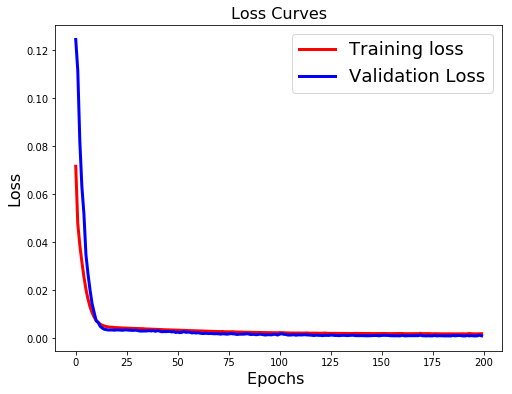

In [38]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [39]:
# Modellperformance bewerten: normalisierte Daten
trainScore = model.evaluate(trainX_100N, train_y_100N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_100N, test_y_100N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)


In [40]:
# Vorhersagen generieren
trainPredict_100N = model.predict(trainX_100N)
testPredict_100N = model.predict(testX_100N)

In [41]:
# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(testPredict_100N)
trainPredict_100=scaler.inverse_transform(trainPredict_100N)

# Evaluation
test_MSE=mean_squared_error(test_y_100,testPredict_100)
train_MSE=mean_squared_error(train_y_100,trainPredict_100)

print(test_MSE,train_MSE)

5913192.650851552 10539673.64877049


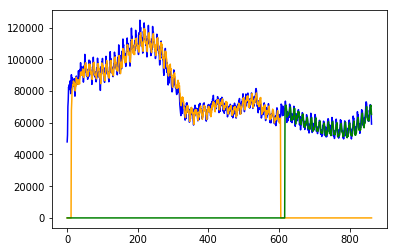

In [42]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_100)+(look_back+look_forward-1)] = trainPredict_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+(2*look_back+look_forward-1):len(ZR_100)-(look_back+look_forward-1)+look_back] = testPredict_100
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [43]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [44]:
# Modell zusammenbauen
# Dateninput: 46 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_46N, train_y_46N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_46N, test_y_46N))

Train on 238 samples, validate on 138 samples
Epoch 1/200
 - 1s - loss: 0.0112 - val_loss: 0.0244
Epoch 2/200
 - 0s - loss: 0.0101 - val_loss: 0.0228
Epoch 3/200
 - 0s - loss: 0.0092 - val_loss: 0.0253
Epoch 4/200
 - 0s - loss: 0.0089 - val_loss: 0.0230
Epoch 5/200
 - 0s - loss: 0.0082 - val_loss: 0.0178
Epoch 6/200
 - 0s - loss: 0.0078 - val_loss: 0.0189
Epoch 7/200
 - 0s - loss: 0.0073 - val_loss: 0.0174
Epoch 8/200
 - 0s - loss: 0.0069 - val_loss: 0.0140
Epoch 9/200
 - 0s - loss: 0.0064 - val_loss: 0.0144
Epoch 10/200
 - 0s - loss: 0.0061 - val_loss: 0.0137
Epoch 11/200
 - 0s - loss: 0.0057 - val_loss: 0.0112
Epoch 12/200
 - 0s - loss: 0.0054 - val_loss: 0.0105
Epoch 13/200
 - 0s - loss: 0.0051 - val_loss: 0.0099
Epoch 14/200
 - 0s - loss: 0.0049 - val_loss: 0.0092
Epoch 15/200
 - 0s - loss: 0.0047 - val_loss: 0.0074
Epoch 16/200
 - 0s - loss: 0.0043 - val_loss: 0.0082
Epoch 17/200
 - 0s - loss: 0.0042 - val_loss: 0.0069
Epoch 18/200
 - 0s - loss: 0.0039 - val_loss: 0.0062
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 155/200
 - 0s - loss: 0.0011 - val_loss: 9.6172e-04
Epoch 156/200
 - 0s - loss: 0.0011 - val_loss: 9.7549e-04
Epoch 157/200
 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 158/200
 - 0s - loss: 0.0011 - val_loss: 8.8606e-04
Epoch 159/200
 - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 160/200
 - 0s - loss: 0.0011 - val_loss: 8.8523e-04
Epoch 161/200
 - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 162/200
 - 0s - loss: 0.0011 - val_loss: 8.7578e-04
Epoch 163/200
 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 164/200
 - 0s - loss: 0.0011 - val_loss: 9.2200e-04
Epoch 165/200
 - 0s - loss: 0.0011 - val_loss: 9.5018e-04
Epoch 166/200
 - 0s - loss: 0.0011 - val_loss: 9.6755e-04
Epoch 167/200
 - 0s - loss: 0.0011 - val_loss: 9.7033e-04
Epoch 168/200
 - 0s - loss: 0.0011 - val_loss: 9.1994e-04
Epoch 169/200
 - 0s - loss: 0.0011 - val_loss: 9.0159e-04
Epoch 170/200
 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 171/200
 - 0s - loss: 0.0010 - v

Text(0.5,1,'Loss Curves')

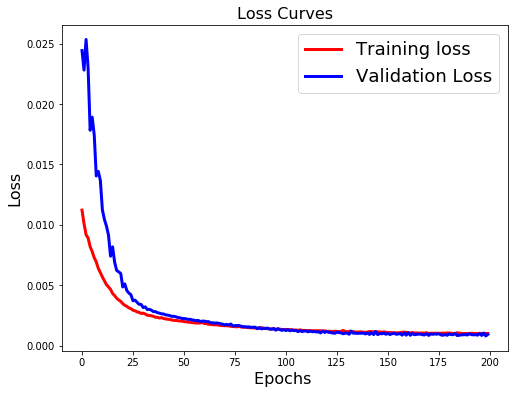

In [45]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [46]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_46N, train_y_46N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_46N, test_y_46N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.03 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)


In [47]:
# Vorhersagen generieren
trainPredict_46N = model.predict(trainX_46N)
testPredict_46N = model.predict(testX_46N)

In [48]:
# Prediction Denormalizing
testPredict_46=scaler.inverse_transform(testPredict_46N)
trainPredict_46=scaler.inverse_transform(trainPredict_46N)

# Evaluation
test_MSE=mean_squared_error(test_y_46,testPredict_46)
train_MSE=mean_squared_error(train_y_46,trainPredict_46)

print(test_MSE,train_MSE)

5581504.701083086 5865990.4019722175


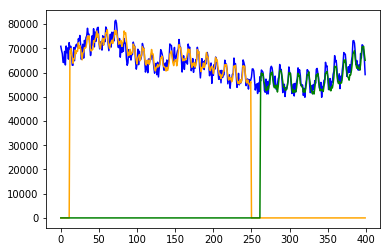

In [51]:
# Verschiebund der Trainingsvorhersage zum Plotten

trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_46)+(look_back+look_forward-1)] = trainPredict_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(trainPredict_46)+(2*look_back+look_forward-1):len(ZR_46)-(look_back+look_forward-1)+look_back] = testPredict_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [100]:
# Replizierbarkeit gewährleisten
np.random.seed(4)

In [101]:
# Modell zusammenbauen
# Dateninput: 12 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_12N, train_y_12N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_12N, test_y_12N))

Train on 38 samples, validate on 38 samples
Epoch 1/200
 - 1s - loss: 0.6658 - val_loss: 0.8630
Epoch 2/200
 - 0s - loss: 0.6381 - val_loss: 0.8271
Epoch 3/200
 - 0s - loss: 0.6111 - val_loss: 0.7922
Epoch 4/200
 - 0s - loss: 0.5848 - val_loss: 0.7581
Epoch 5/200
 - 0s - loss: 0.5591 - val_loss: 0.7250
Epoch 6/200
 - 0s - loss: 0.5341 - val_loss: 0.6927
Epoch 7/200
 - 0s - loss: 0.5099 - val_loss: 0.6614
Epoch 8/200
 - 0s - loss: 0.4862 - val_loss: 0.6310
Epoch 9/200
 - 0s - loss: 0.4634 - val_loss: 0.6015
Epoch 10/200
 - 0s - loss: 0.4413 - val_loss: 0.5729
Epoch 11/200
 - 0s - loss: 0.4198 - val_loss: 0.5453
Epoch 12/200
 - 0s - loss: 0.3991 - val_loss: 0.5187
Epoch 13/200
 - 0s - loss: 0.3791 - val_loss: 0.4929
Epoch 14/200
 - 0s - loss: 0.3598 - val_loss: 0.4681
Epoch 15/200
 - 0s - loss: 0.3413 - val_loss: 0.4442
Epoch 16/200
 - 0s - loss: 0.3233 - val_loss: 0.4213
Epoch 17/200
 - 0s - loss: 0.3061 - val_loss: 0.3992
Epoch 18/200
 - 0s - loss: 0.2897 - val_loss: 0.3780
Epoch 19/20

Epoch 154/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 155/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 156/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 157/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 158/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 159/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 160/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 161/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 162/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 163/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 164/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 165/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 166/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 167/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 168/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 169/200
 - 0s - loss: 0.0026 - val_loss: 0.0036
Epoch 170/200
 - 0s - loss: 0.0025 - val_loss: 0.0036
Epoch 171/200
 - 0s - loss: 0.0025 - val_loss: 0.0036
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

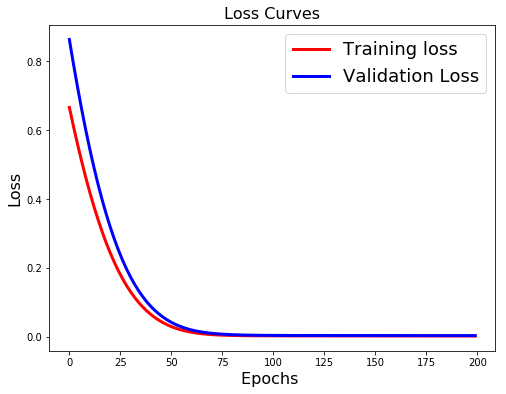

In [102]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [103]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_12N, train_y_12N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_12N, test_y_12N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 0.00 MSE (0.06 RMSE)


In [104]:
# Vorhersagen generieren
trainPredict_12N = model.predict(trainX_12N)
testPredict_12N = model.predict(testX_12N)

In [105]:
# Prediction Denormalizing
testPredict_12=scaler.inverse_transform(testPredict_12N)
trainPredict_12=scaler.inverse_transform(trainPredict_12N)

# Evaluation
test_MSE=mean_squared_error(test_y_12,testPredict_12)
train_MSE=mean_squared_error(train_y_12,trainPredict_12)

print(test_MSE,train_MSE)

20538054.962857295 14432732.068078293


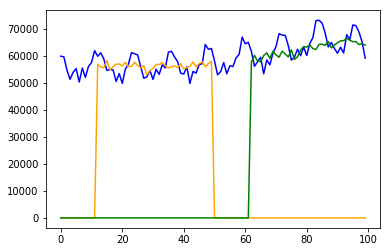

In [107]:
# Verschiebund der Trainingsvorhersage zum Plotten

trainPredictPlot = np.empty_like(ZR_12)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_12))
trainPredictPlot[:]=[0]*len(ZR_12)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_12),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_12)+(look_back+look_forward-1)] = trainPredict_12

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_12)
testPredictPlot=testPredictPlot.reshape(len(ZR_12))
testPredictPlot[:]=[0]*len(ZR_12)
testPredictPlot = testPredictPlot.reshape(len(ZR_12),1)
testPredictPlot[len(trainPredict_12)+(2*look_back+look_forward-1):len(ZR_12)-(look_back+look_forward-1)+look_back] = testPredict_12
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_12, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()